In [26]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from data import get_eval_set
from functools import reduce
import scipy.io as sio
import time
import imageio
import os
import numpy as np
from PIL import Image
import scipy.signal
from matplotlib import pyplot as plt
from pmpanet_x8 import Net as PMBAX8


In [2]:
def downsample(ar,factor):
    kernel = np.full((factor,factor),1/(factor**2))
    ar = scipy.signal.convolve2d(np.asarray(ar),kernel,mode='full')
    ar = ar[factor-1::factor,factor-1::factor]
    return ar
                                

In [7]:
# Create folder of png for the lr depth
directory = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry'

_rgb_files = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/mydataset_7_00002_img.png'
_dist_files = '/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/dist2.dat'

dist_img = torch.load(_dist_files)
dist_img = dist_img.detach().cpu().numpy()
down_img = downsample(dist_img,8)

temp = np.zeros((136,160))
temp[:60,:90] = down_img
print(temp.shape)
im = Image.fromarray(temp)
im = im.convert('L')
im.save(directory+'/distpng/2.png')

rgb_img = imageio.imread(_rgb_files)
temp2 = np.zeros((1088,1280,3))
temp2[:480,:720,:] = rgb_img[:,:,0:3]
print(temp2.shape)
imageio.imsave(directory+'/rgbpng/2.png',temp2)


Lossy conversion from float64 to uint8. Range [0.0, 226.0]. Convert image to uint8 prior to saving to suppress this warning.


(136, 160)
(1088, 1280, 3)


In [8]:
def save_img(img, img_name):

    save_img = img.squeeze().clamp(0, 1).numpy()

    save_dir=os.path.join(opt.output,opt.test_dataset)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_fn = save_dir +'/'+ img_name
    imageio.imwrite(save_fn,save_img*255)

In [9]:
# Testing settings simple geometry
parser = argparse.ArgumentParser(description='PyTorch Super Res Example')
parser.add_argument('--upscale_factor', type=int, default=8, help="super resolution upscale factor")
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--gpu_mode', type=bool, default=False)
parser.add_argument('--threads', type=int, default=1, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--gpus', default=1, type=float, help='number of gpu')
parser.add_argument('--input_dir', type=str, default='/home/beast2020/Desktop/mingchi/')
parser.add_argument('--output', default=directory, help='Location to save checkpoint models')
parser.add_argument('--test_dataset', type=str, default=directory+'/distpng/')
parser.add_argument('--test_rgb_dataset', type=str, default=directory+'/rgbpng/')
parser.add_argument('--model_type', type=str, default='PMBAX8')
parser.add_argument('--model', default="./pre_train_model/PMBA_color_x8.pth", help='pretrained x8 model')

opt = parser.parse_args("")

gpus_list=range(opt.gpus)
print(opt)

Namespace(gpu_mode=False, gpus=1, input_dir='/home/beast2020/Desktop/mingchi/', model='./pre_train_model/PMBA_color_x8.pth', model_type='PMBAX8', output='/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry', seed=123, testBatchSize=1, test_dataset='/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/distpng/', test_rgb_dataset='/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry/rgbpng/', threads=1, upscale_factor=8)


In [10]:

cuda = opt.gpu_mode
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)
if cuda:
    torch.cuda.manual_seed(opt.seed)

print('===> Loading datasets')
test_set = get_eval_set(os.path.join(opt.input_dir,opt.test_dataset),os.path.join(opt.input_dir,opt.test_rgb_dataset))
testing_data_loader = DataLoader(dataset=test_set, batch_size=opt.testBatchSize, shuffle=False)

print('===> Building model')
if opt.model_type == 'PMBAX8':
    model = PMBAX8(num_channels=1, base_filter=64,  feat = 256, num_stages=3, scale_factor=opt.upscale_factor) ##For NTIRE2018
else:
    model = PMBAX8(base_filter=64,  feat = 256, num_stages=5, scale_factor=opt.upscale_factor) ###D-DBPN
####
if cuda:
    model = torch.nn.DataParallel(model, device_ids=gpus_list)

if os.path.exists(opt.model):
    model.load_state_dict(torch.load(opt.model, map_location=lambda storage, loc: storage))
    print('Pre-trained x8 model is loaded.<---------------------------->')

if cuda:
    model = model.cuda(gpus_list[0])



===> Loading datasets
===> Building model


/home/beast2020/Desktop/mingchi/PMBANet_TOPO/pmpanet_x8.py:104: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/home/beast2020/Desktop/mingchi/PMBANet_TOPO/pmpanet_x8.py:108: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)


Pre-trained x8 model is loaded.<---------------------------->


In [11]:
model.eval()
torch.set_grad_enabled(False)


In [12]:

for batch in testing_data_loader:
    input_i,input_rgb, name = Variable(batch[0],volatile=True),Variable(batch[1],volatile=True), batch[2]
    if cuda:
        input_i = input_i.cuda(gpus_list[0])
        input_rgb = input_rgb.cuda(gpus_list[0])
    t0 = time.time()
    prediction = model(input_rgb,input_i)
    t1 = time.time()
    print("===> Processing: %s || Timer: %.4f sec." % (name[0], (t1 - t0)))
    save_img(prediction.cpu().data, name[0])




/tmp/ipykernel_1255858/1991822337.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_i,input_rgb, name = Variable(batch[0],volatile=True),Variable(batch[1],volatile=True), batch[2]
Lossy conversion from float32 to uint8. Range [0.2314152717590332, 98.28373718261719]. Convert image to uint8 prior to saving to suppress this warning.


===> Processing: 2.png || Timer: 26.3844 sec.


In [14]:
to_save = prediction.squeeze().clamp(0, 1).numpy()

In [17]:
imageio.imwrite(directory+'/predict.png',to_save*255)

Lossy conversion from float32 to uint8. Range [0.2314152717590332, 98.28373718261719]. Convert image to uint8 prior to saving to suppress this warning.


In [16]:
directory

'/home/beast2020/Desktop/mingchi/Dataset_with_simple_geometry'

In [28]:

scale_min = np.min(dist_img)
scale_max = np.max(dist_img)
print(scale_min)
print(scale_max)
pred = to_save[:480,:720]
print(np.min(temp))
print(np.max(temp))
err =pred*255 - dist_img
MAE_error = np.mean(np.abs(err))
print(MAE_error)
error_imgs = np.asarray(err)

63.67227026643547
96.41430554631606
0.00090751087
0.38542643
0.6158043017470411


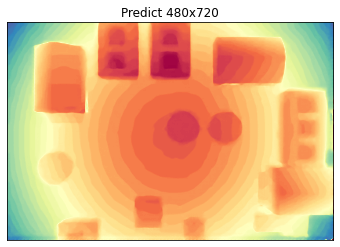

In [31]:
vmin = np.min(dist_img)
vmax = np.max(dist_img)
cmap = 'Spectral'
#predict
plt.imshow(pred*255,vmin = vmin,vmax = vmax,cmap=cmap)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Predict 480x720')
plt.savefig(directory+'/P_2.png',bbox_inches='tight')

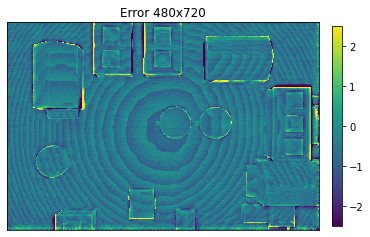

In [33]:
#error

error = plt.imshow(error_imgs,vmin = -2.5, vmax = 2.5,interpolation='none')
cbar1 = plt.colorbar(error,fraction=0.03,pad=0.04)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
plt.title('Error 480x720')
plt.savefig(directory+'/E_2.png',bbox_inches='tight')

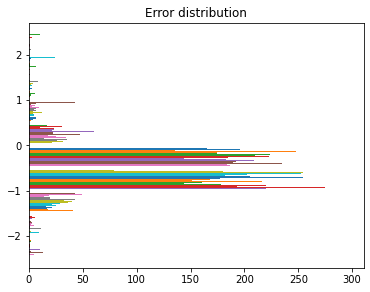

In [34]:
# error distribution
plt.figure(figsize=(4*1.5,3*1.5))
plt.hist(error_imgs,orientation='horizontal',range=(-2.5,2.5));
plt.title('Error distribution')
plt.savefig(directory+'/Drange_2.png',bbox_inches='tight')